In [11]:
import phasenet.zernike as Z
import phasenet.psf as P
import phasenet.model as M
from phasenet.phantoms import *
from tqdm import tqdm
import matplotlib.pyplot as plt

### The phasenet model can be trained using the following three steps: 

### STEP 1 : Setup the config

##### Following parameters needs to be set for the config file:

*zernike_amplitude_ranges* : dictionary or list, the values should either a scalar indicating the absolute magnitude or a tuple with upper and lower bound, default is {'vertical coma':(-0.2,0.2)}

*zernike_order* : string, zernike nomeclature used when the amplitude ranges are given as a list, default is 'noll'

*zernike_normed* : booelan, whether the zzernikes are normalized according, default is True

*net_kernel_size* : convoltuion kernel size, default is (3,3,3)

*net_pool_size* : max pool kernel size, default is (1,2,2)

*net_activation* : activation, default is 'tanh'

*net_padding* : padding for convolution, default is 'same'

*psf_shape* : tuple, shpae of the psf, default is (64,64,64)

*psf_units* : tuple, voxel unit (z,y,x) in um, default is (0.1,0.1,0.1)

*psf_na_detection* : scalar, numerical apperture default is 1.1

*psf_lam_detection* : scalar, wavelength in um, default is 0.5

*psf_n*: scalar, refractive index of immersion medium, default is 1.33

*noise_snr* : scalar or tuple, signal to noise ratio

*noise_mean* : scalar or tuple, mean background noise

*noise_sigma* : scalar or tuple, simga for gaussian noise

*gaussian_blur_sigma* : float, sigma for gaussian bluring after adding noise, default is None

*phantom_params* : dictionary, parameters for the chosen phantom, e.g. {'name'='sphere',radius':0.1}. The phantom should belong ot the phantom class.

*crop_shape* : tuple, crop shape

*jitter* : booelan, randomly move the center point within a given limit, default is False

*max_jitter* : tuple, maximum displacement for jittering, if None then it gets a default value

*train_loss* : string, training loss, default is 'mse'

*train_epochs*: integer, number of epochs for trianing, default is 400

*train_steps_per_epoch* : integer, number of steps per epoch, default is 5

*train_learning_rate* : scalar, leaning rate, default is 0.0003

*train_batch_size* : integer, batch size for training the network, default is 8

*train_n_val* : integer, number of validation data, default is 128

*train_tensorboard* : boolean, create tensorboard, default is True

*planes* : list, z planes with respect to center, if None then it takes all the planes

In [3]:
c = M.Config(psf_n=8,phantom_params=None)
vars(c)

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'zernike_amplitude_ranges': {'vertical coma': (-0.2, 0.2)},
 'zernike_order': 'noll',
 'zernike_normed': True,
 'net_kernel_size': (3, 3, 3),
 'net_pool_size': (1, 2, 2),
 'net_activation': 'tanh',
 'net_padding': 'same',
 'psf_shape': (64, 64, 64),
 'psf_units': (0.1, 0.1, 0.1),
 'psf_na_detection': 1.1,
 'psf_lam_detection': 0.5,
 'psf_n': 8,
 'noise_mean': 100,
 'noise_sigma': 3.5,
 'noise_snr': (1.0, 5),
 'gaussian_blur_sigma': None,
 'phantom_params': None,
 'crop_shape': (32, 32, 32),
 'jitter': True,
 'max_jitter': None,
 'planes': None,
 'train_loss': 'mse',
 'train_epochs': 400,
 'train_steps_per_epoch': 5,
 'train_learning_rate': 0.0003,
 'train_batch_size': 8,
 'train_n_val': 128,
 'train_tensorboard': True,
 'model_input_shape': (32, 32, 32)}

## STEP 2 : Setup the model

#### Following parameters needs to be set for the model:

*config* : Config file

*name* :  Name of the model

*basedir* : Base directory to save the model

In [4]:
model = M.PhaseNet(config=c, name='test', basedir='models')

/Users/dsaha/anaconda/lib/python3.6/site-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /Users/dsaha/Codes/phase_net_code/notebooks/models/test
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


## STEP 3: Train the model

In [5]:
model.train(epochs=20)

Epoch 1/20
5/5 [==============================] - 26s 5s/step - loss: 0.0199 - val_loss: 0.0124
Epoch 2/20
5/5 [==============================] - 25s 5s/step - loss: 0.0145 - val_loss: 0.0114
Epoch 3/20
5/5 [==============================] - 25s 5s/step - loss: 0.0087 - val_loss: 0.0040
Epoch 4/20
5/5 [==============================] - 24s 5s/step - loss: 0.0025 - val_loss: 0.0034
Epoch 5/20
5/5 [==============================] - 25s 5s/step - loss: 0.0018 - val_loss: 9.4923e-04
Epoch 6/20
5/5 [==============================] - 24s 5s/step - loss: 0.0016 - val_loss: 8.1531e-04
Epoch 7/20
5/5 [==============================] - 25s 5s/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/20
5/5 [==============================] - 24s 5s/step - loss: 0.0013 - val_loss: 9.4298e-04
Epoch 9/20
5/5 [==============================] - 24s 5s/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/20
5/5 [==============================] - 25s 5s/step - loss: 0.0014 - val_loss: 0.0012
Epoch 11/20
5/5 [==========

### Validation on synthetic data

In [6]:
data = M.Data(
    batch_size           = 10,
    amplitude_ranges     = model.config.zernike_amplitude_ranges,
    order                = model.config.zernike_order,
    normed               = model.config.zernike_normed,
    psf_shape            = model.config.psf_shape,
    units                = model.config.psf_units,
    na_detection         = model.config.psf_na_detection,
    lam_detection        = model.config.psf_lam_detection,
    n                    = model.config.psf_n,
    noise_mean           = model.config.noise_mean,
    noise_snr            = model.config.noise_snr,
    noise_sigma          = model.config.noise_sigma,
    crop_shape           = model.config.crop_shape,
    jitter               = model.config.jitter,
    phantom_params       = model.config.phantom_params,
    planes               = model.config.planes,
)
psfs, amps = next(data.generator())
psfs.shape
amps.shape

(10, 32, 32, 32, 1)

(10, 1)

In [32]:
amps_pred = np.array([model.predict(psf) for psf in tqdm(psfs)])

100%|██████████| 10/10 [00:00<00:00, 16.51it/s]


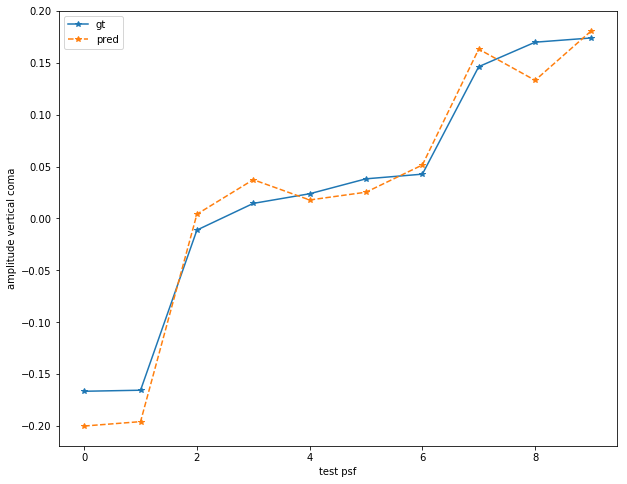

In [39]:
plt.figure(figsize=(10,8))
ind = np.argsort(amps.ravel())
plt.plot(amps[ind], marker='*',label='gt')
plt.plot(amps_pred[ind], '--',marker='*', label='pred')
# plt.hlines(-0.2, *plt.axis()[:2])
# plt.hlines(+0.2, *plt.axis()[:2])
plt.xlabel('test psf')
plt.ylabel(f'amplitude {tuple(model.config.zernike_amplitude_ranges.keys())[0]}')
plt.legend()
None;